In [1]:
import numpy as np
import math
import itertools
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import time
import networkx as nx

In [2]:
Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
I = np.eye(2)

In [3]:
# produce all binary strings of length n with k 1s. If k is None then all possible binary strings of length n produced
def get_binary_strings(n, k=None):
    final = []
    def kbits(r):
        result = []
        for bits in itertools.combinations(range(n), r):
            s = ['0'] * n
            for bit in bits:
                s[bit] = '1'
            result.append(''.join(s))   
        return result

    if k != None:
        return kbits(k)
    
    for i in range(n + 1):
        final = final + kbits(i)
        
    return final



In [4]:

# lst is a list of pairs where pauli matrix is paired with ith qubit
def get_circuit_operators(nqubits, lst):
    temp = [I]*nqubits
    for i in range(len(lst)):
        temp[lst[i][1] - 1] = lst[i][0]
    
    ans = temp[0]
    
    for matrix in temp[1:]:
        ans = np.kron(ans, matrix)
    
    # returns for example X @ I @ I @ X @ I where @ is tensor product
    return ans


# coefficients don't matter, but gamma must not equal = (pi/2 + pi*k), (pi + pi*k), beta must not equal = pi/4
# if not coefficients will be lost
def generate_QAOA_operator(nqubits, locality, number_of_terms):
    # choosing both beta and gamma to have the same angle
    beta_angle = np.pi/12
    cos_angle = np.cos(beta_angle)
    sin_angle = np.sin(beta_angle)
    # randomly pick "number_of_terms" Z operators based on locality and sum them up to form H 
    Zs = get_binary_strings(nqubits, locality)
    random.shuffle(Zs)
    identity = np.eye(2**nqubits)
    
    
    ZiZjs = list()
    
    H = np.zeros((2**nqubits, 2**nqubits))
    
    # turn binary strings into matrices of ZiZj
    for i in range(number_of_terms):
        tempZ = list()
        for j in enumerate(Zs[i]):
            if j[1] == "1":
                tempZ.append((Z, j[0] + 1))
        # print("temp Z:", tempZ)
        ZiZjs.append(get_circuit_operators(nqubits, tempZ))
    # print("ZiZj:",ZiZjs)
    for matrix in ZiZjs:
        H += matrix
    
    
    # Form unitary of mixer Hamiltonian
    unitary_x = identity
    
    temp_X_list = [[(X, i + 1)] for i in range(nqubits)]
    for Xi in temp_X_list:
        unitary_x  = unitary_x @ (cos_angle * identity -1j * sin_angle * get_circuit_operators(nqubits, Xi))
        
    unitary_x_ct = np.conj(unitary_x).T
    
    # Form unitary of H
    unitary_z = identity
    for i in ZiZjs:
        unitary_z = unitary_z @ (cos_angle *identity -1j * sin_angle * i)
        
    
    unitary_z_ct = np.conj(unitary_z).T
    
    # operator in expected value
    ans = unitary_z_ct @ unitary_x_ct @ H @ unitary_x @ unitary_z
    
    # print(unitary_z_ct ,";;\n", unitary_x_ct ,";;\n", H )
    if locality == 2:
        return ans, Zs[:number_of_terms]
        
    return ans


In [5]:


# X and I only
def get_pauli_coefficients(H):
    non_zero_pauli_strings = list()
    
    nonzero = 0
    # make pauli strings of X and I only using a binary string where 0 is mapped to X and 1 to I
    # X->0, I->1
    #{X, I}^number of terms(n)
    def kronecker_product_sequence(binary_string):
        lst = [X, I]
        ans = lst[int(binary_string[0])]
        
        for i in binary_string[1:]:
            ans = np.kron(ans, lst[int(i)])
            
        return ans
        
            
    hamiltonian_size = H.shape[0]
    n = int(math.log2(hamiltonian_size))
    bin_strings = get_binary_strings(n)
    for string in bin_strings:
        pauli_string = kronecker_product_sequence(string)
        coefficient = 1/H.shape[0] * np.trace(pauli_string@H) 
        # print(coefficient, pauli_string)
        if np.real(coefficient) > 1e-10 or np.imag(coefficient) > 1e-10:
            non_zero_pauli_strings.append((string, coefficient))
            nonzero += 1
       
    return nonzero, non_zero_pauli_strings


def fill_locality_x_terms_grid(nqubits, with_graph=False):
    def generate_graph_for_locality2(Zs):
        nodes = [0]*nqubits
        edges = list()
        for string in Zs:
            temp_nodes = list()
            for bit in range(len(string)):
                if string[bit] == "1":
                    temp_nodes.append(bit)
            nodes[temp_nodes[0]] = 1
            nodes[temp_nodes[1]] = 1
            edges.append((temp_nodes[0], temp_nodes[1]))

        nodes = [i for i in range(len(nodes)) if nodes[i] == 1]
        G = nx.Graph()
        G.add_nodes_from(nodes)
        G.add_edges_from(edges)
        
        if with_graph:
            pos = nx.spiral_layout(G)
            fig, ax = plt.subplots()
            fig.set_figwidth(3)
            fig.set_figheight(3)
            nx.draw_networkx(G, ax=ax, labels={n: n for n in G})
        
        return G
        
    
    # number of coefficients for level 1 = 3 * no. of triangles + no. of non-isolated nodes
    def check_count_of_coefficients_locality2(G):
        number_of_triangles = sum(nx.triangles(G).values()) # this is already multiplied by 3
        number_of_non_isolated_vertices = 0
        
        for node in list(G.nodes):
            if G.degree[node] > 0:
                number_of_non_isolated_vertices += 1
                
        return number_of_non_isolated_vertices + number_of_triangles        
        
        
    start = time.time()
    hamiltonian_pauli_strings = list()
    number_of_terms = range(1, nqubits + 1)
    locality = range(1, nqubits + 1)
    
    # grid has shape locality by number of terms
    number_of_non_zero_coefficients = list()
    
    for i in locality:
        temp_list = list()
        pauli_temp_list = list()
        
        all_good = True
        for j in number_of_terms:
            if i == nqubits and j > 1:
                temp_list.append(0)
                continue
            
            H = generate_QAOA_operator(nqubits, i, j)
            non_zero, string = get_pauli_coefficients(H[0]) if i == 2 else get_pauli_coefficients(H)
            
            # check if counting is same as code
            if i == 2:
                G = generate_graph_for_locality2(H[1])
                count = check_count_of_coefficients_locality2(G)
                if  count != non_zero:
                    all_good = False
                    print(count)
                    
            temp_list.append(non_zero)
            pauli_temp_list.append(string)
        
        if i == 2:
            if all_good:
                print("\033[92m {}\033[00m".format("At this juncture counting has made a consensus with this code."\
                        "By the power invested in me by the Great Akshay,"\
                        "I declare this a point where the theory meets with the practical"))
                print("\033[91m {}\033[00m".format("NOTE: Check is done for locality 2. "\
                        "Along with Akshay we shall pull the sword out of the stone as King Arthur did"))
            else:
                print("Damn thy are not worthy")
                print(count)
                
        number_of_non_zero_coefficients.append(temp_list)
        hamiltonian_pauli_strings.append(pauli_temp_list)
        
    end = time.time()
    
    print("Time for {}qubits: {}".format(nqubits, end-start))

    return number_of_non_zero_coefficients, hamiltonian_pauli_strings


In [6]:


def plot_grid(grid):

    localities = [i + 1 for i in range(len(grid))]
    num_of_terms = [i + 1 for i in range(len(grid[0]))]


    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(grid, interpolation='nearest', cmap='plasma')
    fig.colorbar(cax)

    ax.set_xticklabels(['']+localities)
    ax.set_yticklabels(['']+num_of_terms)
    
    for index, locality in enumerate(grid):
        for number_of_terms in range(len(locality)):
            ax.text(number_of_terms, index, str(grid[index][number_of_terms]),  ha='center', va='center')
            
    ax.set_xlabel('No. of Terms', fontsize = 15)
    ax.set_ylabel('Locality', fontsize = 15)
    ax.set_title(str(len(localities)) + " Qubits", fontsize = 20)

    plt.show()

In [8]:
# qubit2, qubit2_pauli = fill_locality_x_terms_grid(2)
# qubit3, qubit3_pauli = fill_locality_x_terms_grid(3)
# qubit4, qubit4_pauli = fill_locality_x_terms_grid(4)
# qubit5, qubit5_pauli = fill_locality_x_terms_grid(5)
# qubit6, qubit6_pauli = fill_locality_x_terms_grid(6)
# qubit7, qubit7_pauli = fill_locality_x_terms_grid(7)
qubit8, qubit8_pauli = fill_locality_x_terms_grid(8)

 At this juncture counting has made a consensus with this code.By the power invested in me by the Great Akshay,I declare this a point where the theory meets with the practical
 NOTE: Check is done for locality 2. Along with Akshay we shall pull the sword out of the stone as King Arthur did
Time for 8qubits: 49.32590317726135


In [9]:
%load_ext line_profiler

In [10]:
%lprun -f fill_locality_x_terms_grid fill_locality_x_terms_grid(5)

 At this juncture counting has made a consensus with this code.By the power invested in me by the Great Akshay,I declare this a point where the theory meets with the practical
 NOTE: Check is done for locality 2. Along with Akshay we shall pull the sword out of the stone as King Arthur did
Time for 5qubits: 0.2451038360595703


Timer unit: 1e-07 s

Total time: 0.245026 s
File: C:\Users\dimav\AppData\Local\Temp\ipykernel_9168\3824910636.py
Function: fill_locality_x_terms_grid at line 33

Line #      Hits         Time  Per Hit   % Time  Line Contents
    33                                           def fill_locality_x_terms_grid(nqubits, with_graph=False):
    34         1         10.0     10.0      0.0      def generate_graph_for_locality2(Zs):
    35                                                   nodes = [0]*nqubits
    36                                                   edges = list()
    37                                                   for string in Zs:
    38                                                       temp_nodes = list()
    39                                                       for bit in range(len(string)):
    40                                                           if string[bit] == "1":
    41                                                               temp_nodes.append(bit)

In [11]:
%lprun -f generate_QAOA_operator generate_QAOA_operator(5, 3, 3)

Timer unit: 1e-07 s

Total time: 0.0043718 s
File: C:\Users\dimav\AppData\Local\Temp\ipykernel_9168\840698522.py
Function: generate_QAOA_operator at line 18

Line #      Hits         Time  Per Hit   % Time  Line Contents
    18                                           def generate_QAOA_operator(nqubits, locality, number_of_terms):
    19                                               # choosing both beta and gamma to have the same angle
    20         1         23.0     23.0      0.1      beta_angle = np.pi/12
    21         1        210.0    210.0      0.5      cos_angle = np.cos(beta_angle)
    22         1         40.0     40.0      0.1      sin_angle = np.sin(beta_angle)
    23                                               # randomly pick "number_of_terms" Z operators based on locality and sum them up to form H 
    24         1        654.0    654.0      1.5      Zs = get_binary_strings(nqubits, locality)
    25         1        474.0    474.0      1.1      random.shuffle(Zs)
    

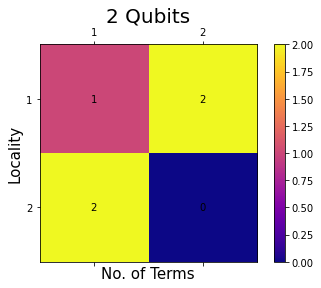

In [97]:
plot_grid(qubit2)

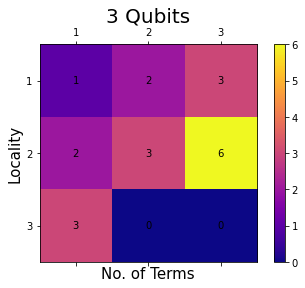

In [98]:
plot_grid(qubit3)

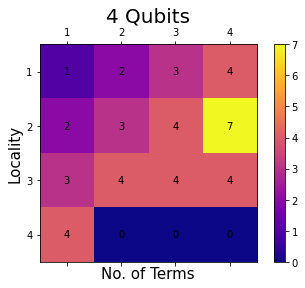

In [99]:
plot_grid(qubit4)

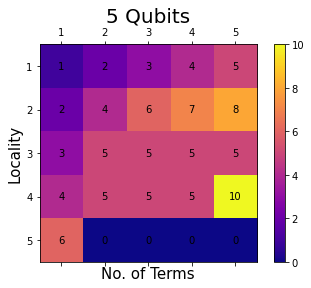

In [100]:
plot_grid(qubit5)

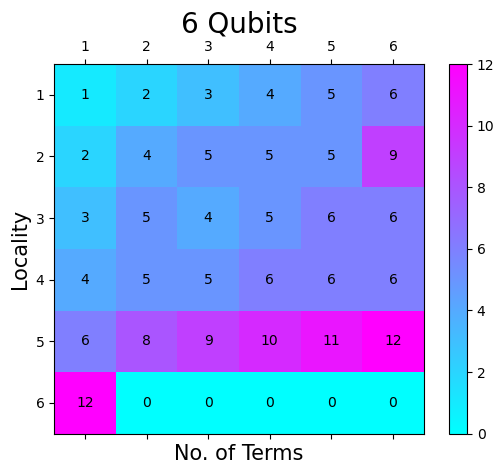

In [9]:
plot_grid(qubit6)

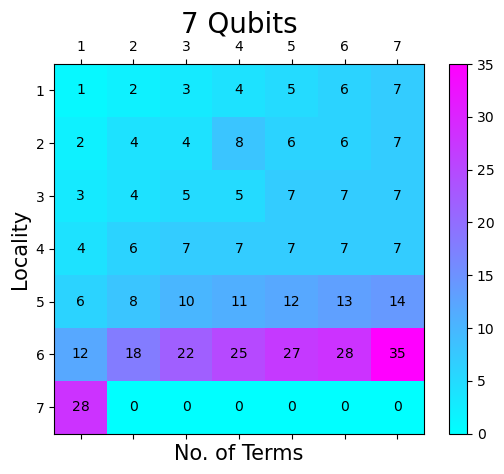

In [10]:
plot_grid(qubit7)

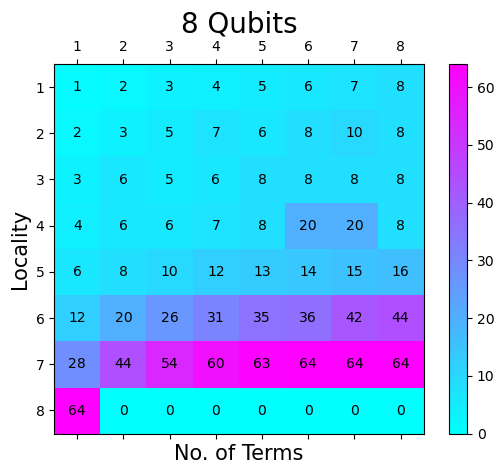

In [11]:
plot_grid(qubit8)